In [1]:
import sys
sys.path.append('/home/dylan-kmutt/ubpd')

In [ ]:
print("hello")

hello


In [3]:
import os
def get_model_paths(model_id):
    model_paths = []
    for path in os.listdir("../../checkpoints"):
        if str(model_id) in path:
            model_paths.append(f"../../checkpoints/{path}")
    model_paths = sorted(model_paths)
    print("Models found: ")
    for i in model_paths:
        print(f"-- {i}")
    return model_paths

In [4]:
from src.evaluate import Evaluator
from src.helper import load_model, aggregate_fold_metrics
from src.preprocessing import PairedTransform
from src.dataset import UBPDataset

In [ ]:
def get_pids(seed, ultrasound):
    if seed == 42:
        if ultrasound == "u1":
            p_ids = [16, 19, 12, 36, 41]
        if ultrasound == "u2":
            p_ids = [61, 77, 79, 50, 75, 94, 68, 96]
        if ultrasound == "combined":
            p_ids = [16, 19, 12, 36, 41, 61, 77, 79, 50, 75, 94, 68, 96]
    elif seed == 94:
        if ultrasound == "u1":
            p_ids = [11, 35, 32, 9, 8]
        if ultrasound == "u2":
            p_ids = [50, 62, 98, 4, 81, 96, 70, 68]
        if ultrasound == "combined":
            p_ids = [11, 35, 32, 9, 8, 50, 62, 98, 4, 81, 96, 70, 68]
    elif seed == 33:
        if ultrasound == "u1":
            p_ids = [38, 19, 10, 42, 8]
        if ultrasound == "u2":
            p_ids = [131, 53, 6, 47, 78, 49, 76, 64]
        if ultrasound == "combined":
            p_ids = [38, 19, 10, 42, 8, 131, 53, 6, 47, 78, 49, 76, 64]
    return p_ids

In [6]:
import numpy as np


def evaluate(variants):
    # CV
    print(f"🚀Begininng evaluating model id {variants['model_id']}\n")
    fold_overall_means = []
    fold_results = []  # store per-fold evaluator outputs (dicts)

    include_classes = variants.get("include_classes")
    class_names = {
        1: "dongmai (artery)",
        2: "jingmai (vein)",
        3: "jirouzuzhi (muscle)",
        4: "shenjing (nerve)",
    }
    print("Included classes:")
    for cid in include_classes:
        print(f"  {cid}: {class_names.get(cid, 'unknown')}")

    include_classes = variants["include_classes"]
    n_inc = len(include_classes)
    if n_inc == 1:
        variants["loss"] = "bce"
        num_classes_for_model = 1  # single foreground channel
    else:
        variants["loss"] = "ce"
        num_classes_for_model = n_inc + 1  # background + selected classes only
    variants["num_classes"] = num_classes_for_model

    p_ids = get_pids(variants["seed"], variants["test_pids"])

    paired_test_tf = PairedTransform(size=variants["image_size"], aug=False)
    test_dataset = UBPDataset(
        p_ids=p_ids,
        include_classes=include_classes,
        image_dir="../../data/dataset/images",
        json_dir="../../data/dataset/labels/json_train",
        joint_transform=paired_test_tf,
        keep_original_indices=True,
    )

    print("\nTest landmarks stat: ")
    test_dataset.print_stats()
    len(test_dataset)

    model_paths = get_model_paths(variants["model_id"])    
    for model_path in model_paths:
        print(f"\nEvaluating: {model_path} ------------------")

        model = load_model(
            model_path,
            model_name=variants["model_name"],
            in_channels=1,
            num_classes=num_classes_for_model,
            device=variants["device"],
        )

        # Evaluate one fold (you can move this after the loop to evaluate the final/best model instead)
        evaluator = Evaluator(
            model,
            test_dataset,
            num_classes=num_classes_for_model,
            ignore_empty_classes=False,
        )
        res = evaluator.evaluate_dice_score(show_plot=True)
        evaluator.visualize_ranked()

        try:
            overall_mean = res.get("overall", {}).get("mean", float("nan"))
        except Exception:
            overall_mean = float("nan")
        fold_overall_means.append(
            float(overall_mean) if overall_mean is not None else float("nan")
        )
        fold_results.append(res)

    overall_mean, overall_std, per_class_stats = aggregate_fold_metrics(fold_results)
    if not np.isnan(overall_mean):
        print(
            f"\n🎯 Average overall Dice across folds: {overall_mean:.4f} ± {overall_std:.4f}  (n={len(fold_results)})"
        )
    else:
        print("\n⚠️ No per-fold overall Dice scores collected.")

    # Print per-landmark (per-class) averages
    if per_class_stats:
        print("\n📌 Per-landmark average Dice across folds:")
        for cid in sorted(per_class_stats.keys()):
            stats = per_class_stats[cid]
            name = class_names.get(cid, f"class_{cid}")
            print(
                f"  {cid}: {name:<20s} mean±std: {stats['mean']:.4f} ± {stats['std']:.4f}  (folds={stats['n_folds']})"
            )
    else:
        print("\n⚠️ No per-class stats available to aggregate.")

    print("\n✅ Experiment complete across folds.")
    return {
        "test_dataset": test_dataset,
        "fold_overall_means": fold_overall_means,
        "fold_results": fold_results
    }


In [14]:
import torch

variants = {
    "include_classes": [1,2,3,4],
    "model_name": "unet",
    "model_id": 111114,
    "test_pids": "u1",
    "image_size": 512,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 42
}

🚀Begininng evaluating model id 111114

Included classes:
  1: dongmai (artery)
  2: jingmai (vein)
  3: jirouzuzhi (muscle)
  4: shenjing (nerve)

Test landmarks stat: 
Artery  present: 42/52 images
Vein    present: 40/52 images
Muscle  present: 51/52 images
Nerve   present: 49/52 images
Models found: 
-- ../../checkpoints/111114_fold_1.pth
-- ../../checkpoints/111114_fold_2.pth
-- ../../checkpoints/111114_fold_3.pth
-- ../../checkpoints/111114_fold_4.pth
-- ../../checkpoints/111114_fold_5.pth

Evaluating: ../../checkpoints/111114_fold_1.pth ------------------



📊 Dice scores (foreground only; INCLUDING empties as Dice=1):
  Overall (pooled) mean±std: 0.3321 ± 0.3152  (n=208)
  artery               mean±std: 0.4189 ± 0.3534  (median=0.4484, n=52)
  vein                 mean±std: 0.3534 ± 0.3460  (median=0.2245, n=52)
  muscle               mean±std: 0.4586 ± 0.1674  (median=0.4715, n=52)
  nerve                mean±std: 0.0975 ± 0.2137  (median=0.0000, n=52)


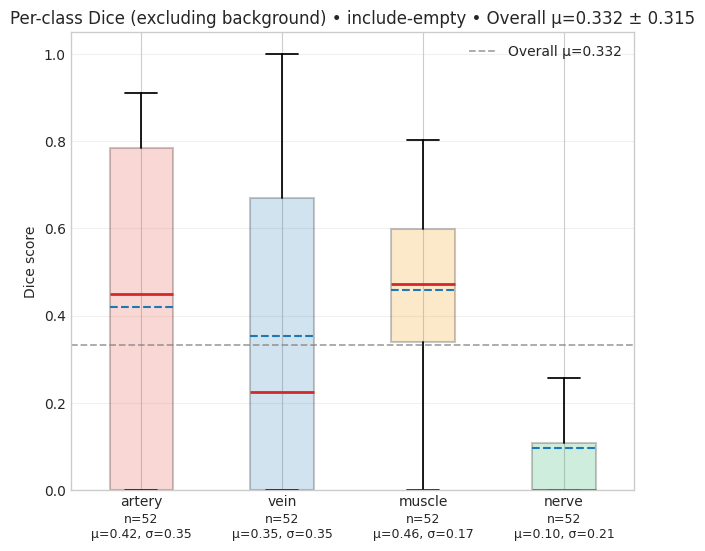

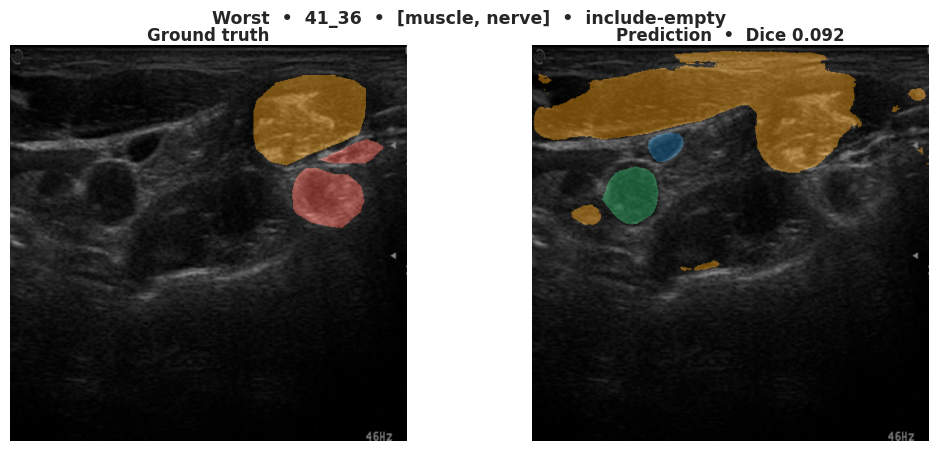

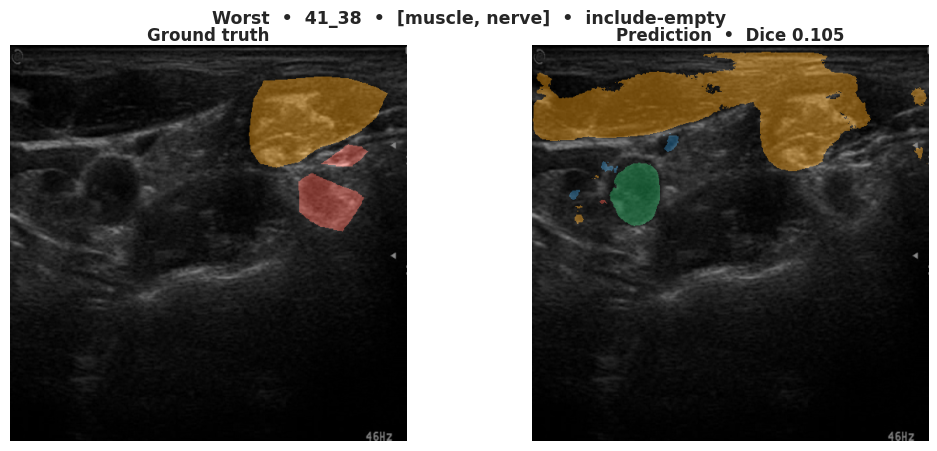

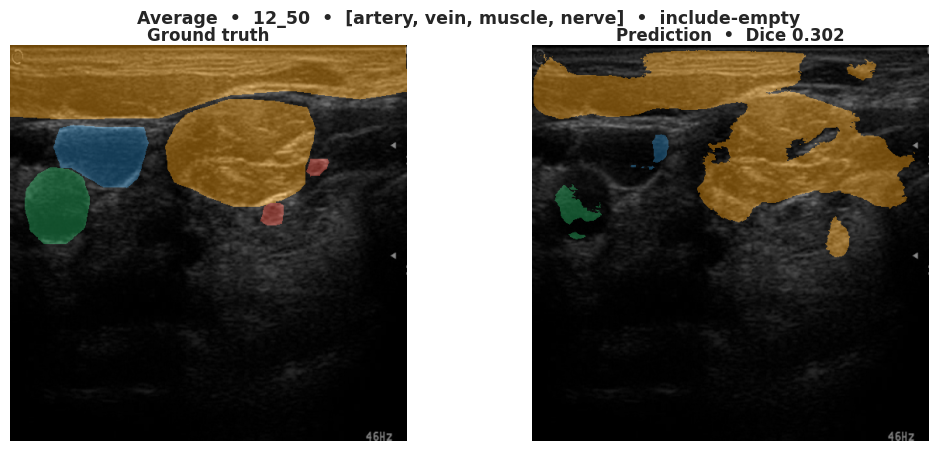

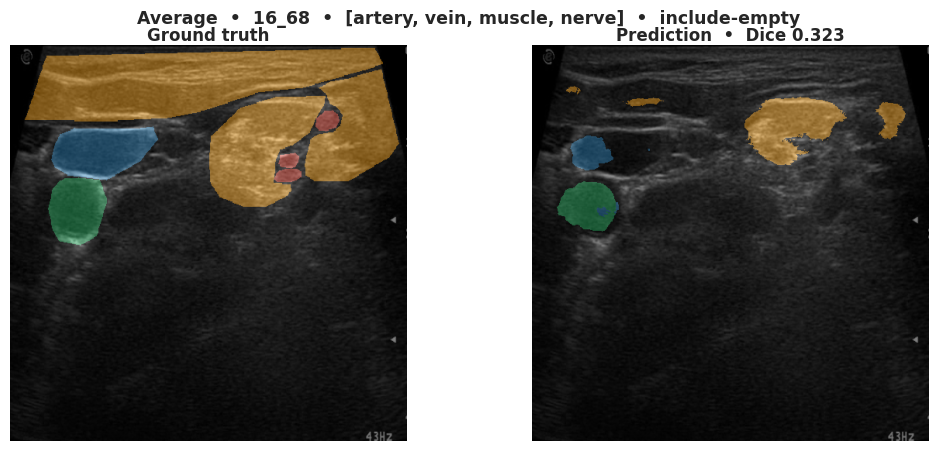

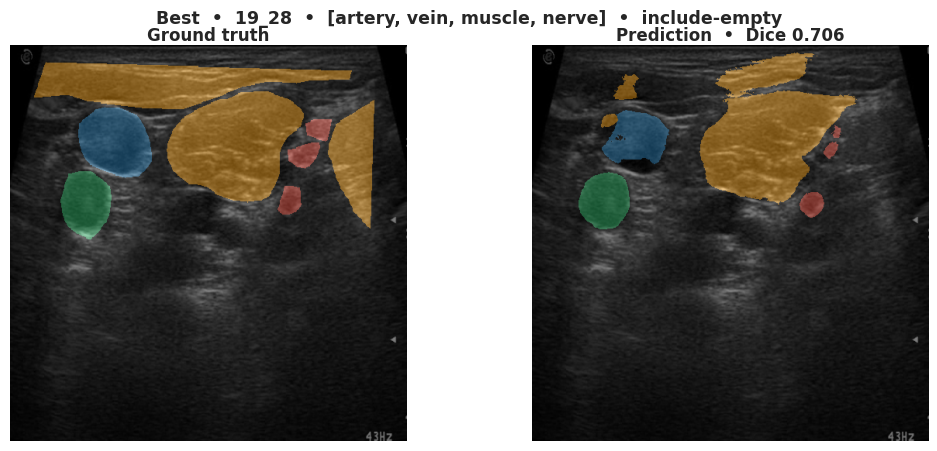

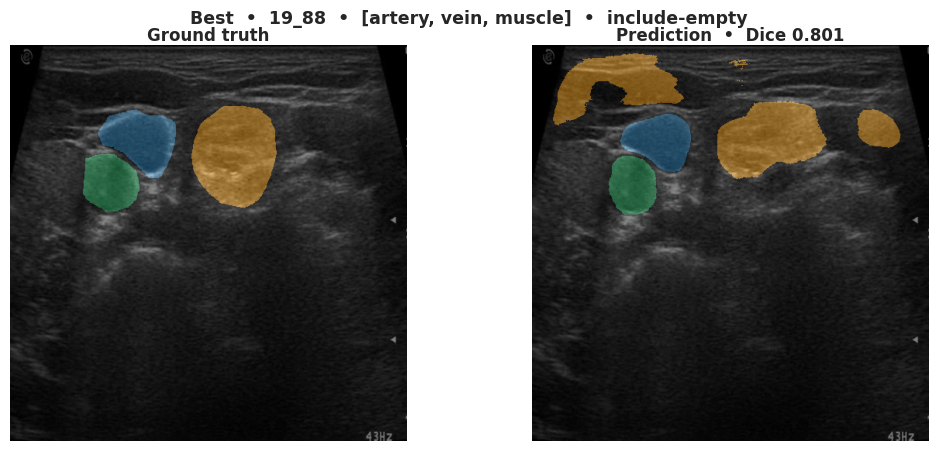


Evaluating: ../../checkpoints/111114_fold_2.pth ------------------

📊 Dice scores (foreground only; INCLUDING empties as Dice=1):
  Overall (pooled) mean±std: 0.3163 ± 0.3176  (n=208)
  artery               mean±std: 0.2987 ± 0.3170  (median=0.1386, n=52)
  vein                 mean±std: 0.3860 ± 0.3277  (median=0.4040, n=52)
  muscle               mean±std: 0.5228 ± 0.1627  (median=0.5369, n=52)
  nerve                mean±std: 0.0577 ± 0.2332  (median=0.0000, n=52)


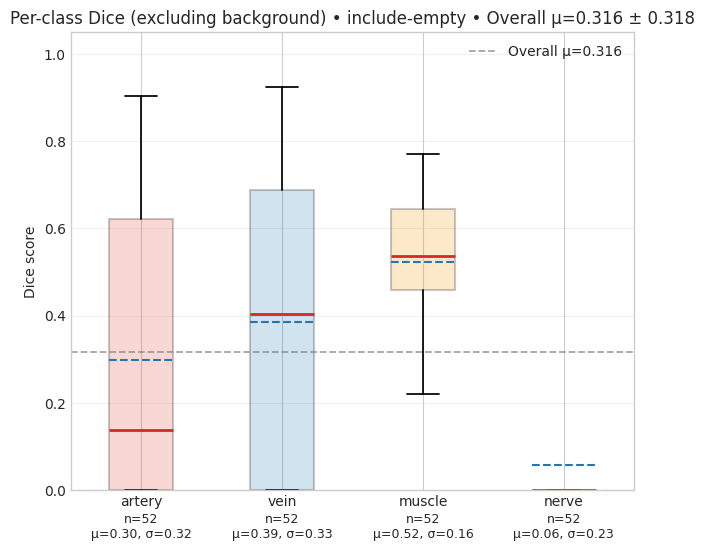

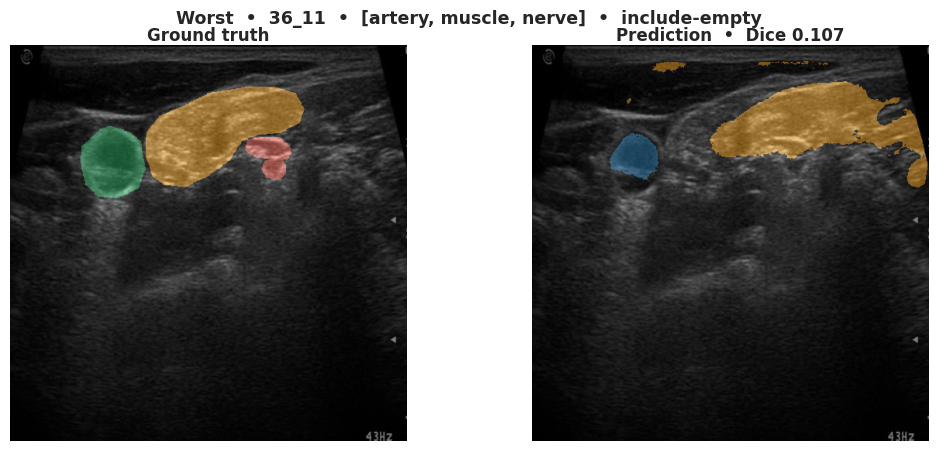

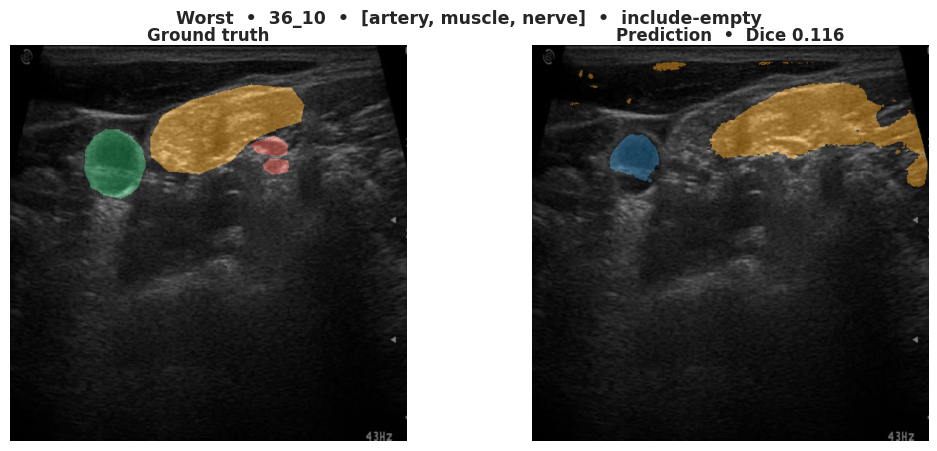

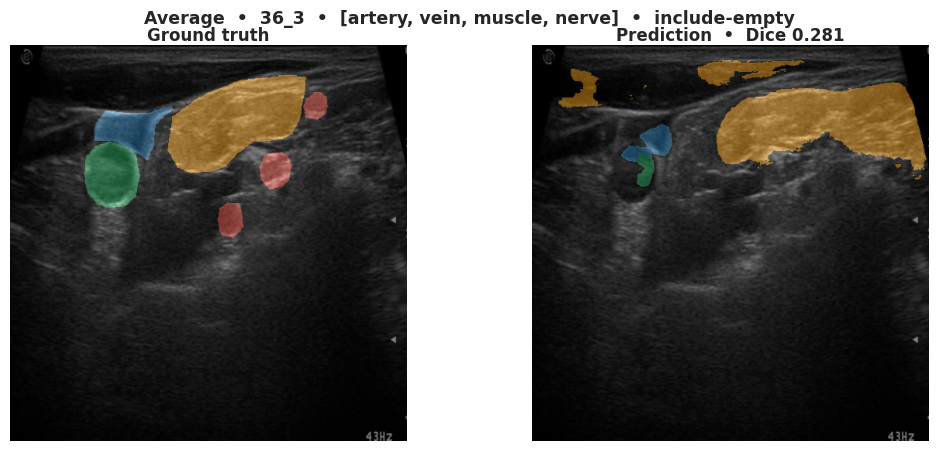

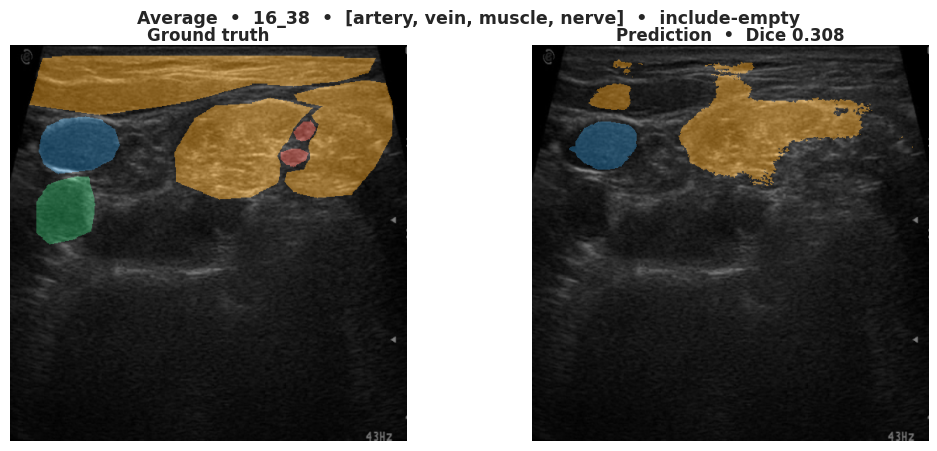

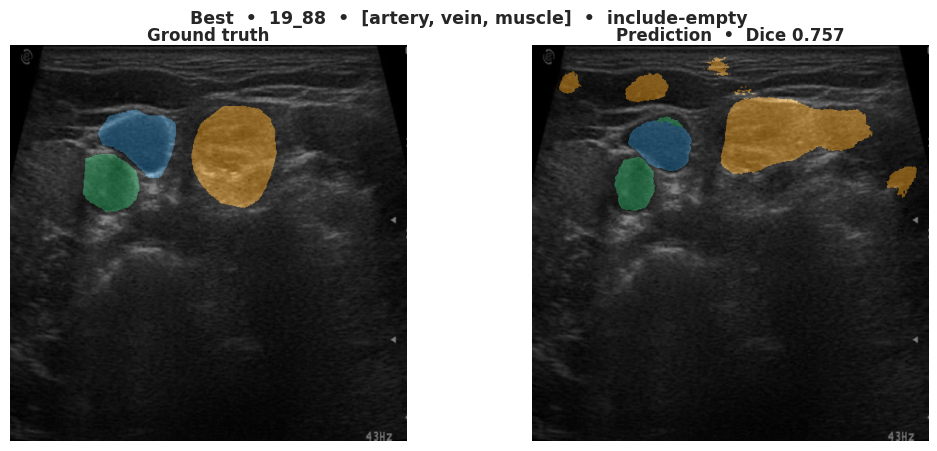

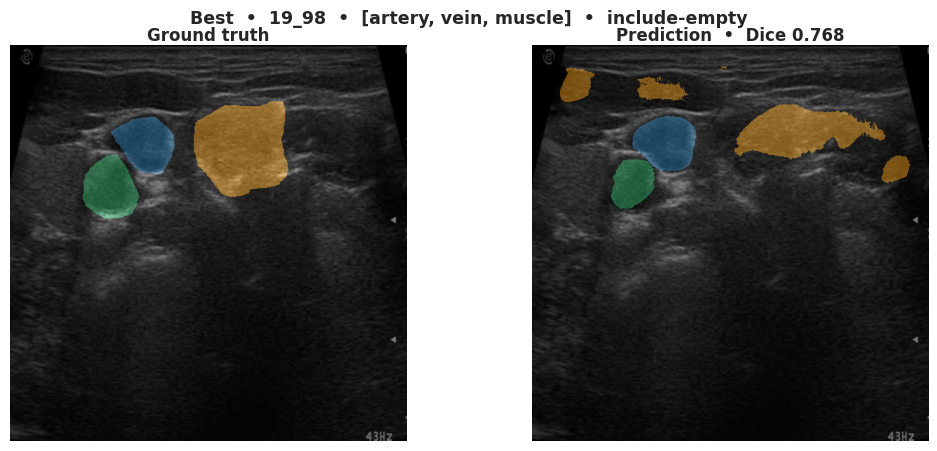


Evaluating: ../../checkpoints/111114_fold_3.pth ------------------

📊 Dice scores (foreground only; INCLUDING empties as Dice=1):
  Overall (pooled) mean±std: 0.4325 ± 0.3303  (n=208)
  artery               mean±std: 0.5974 ± 0.3529  (median=0.7745, n=52)
  vein                 mean±std: 0.4650 ± 0.3529  (median=0.6221, n=52)
  muscle               mean±std: 0.5027 ± 0.1596  (median=0.5068, n=52)
  nerve                mean±std: 0.1649 ± 0.2388  (median=0.0637, n=52)


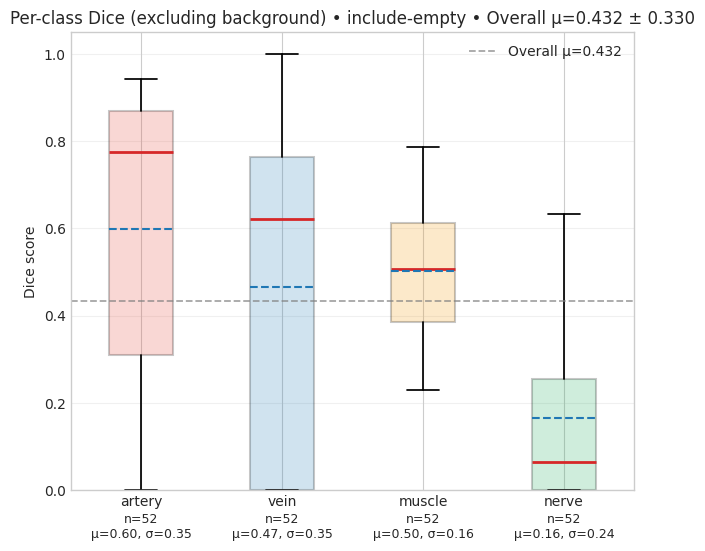

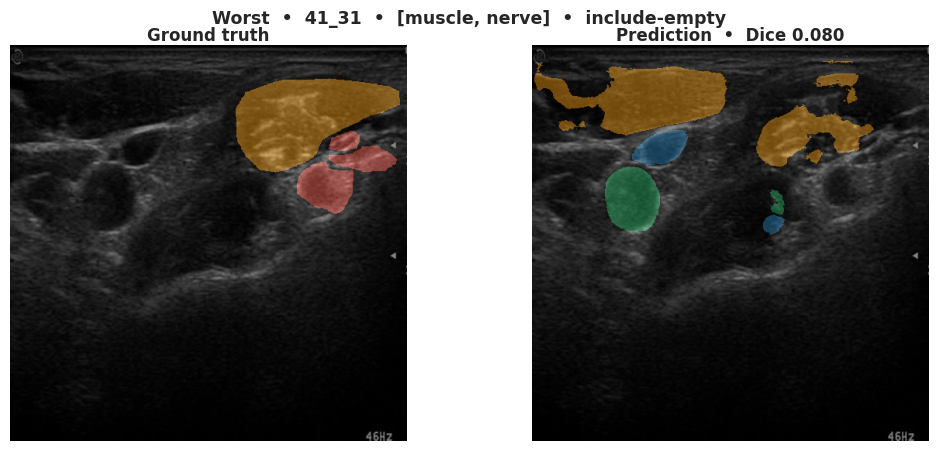

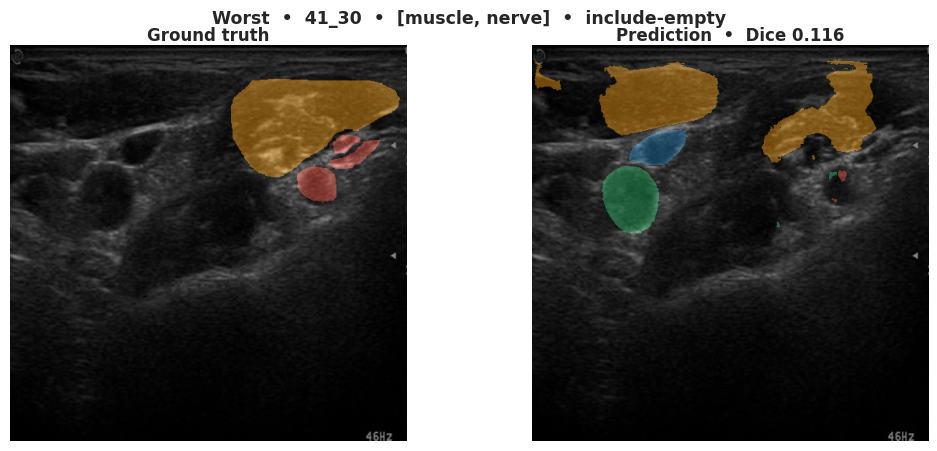

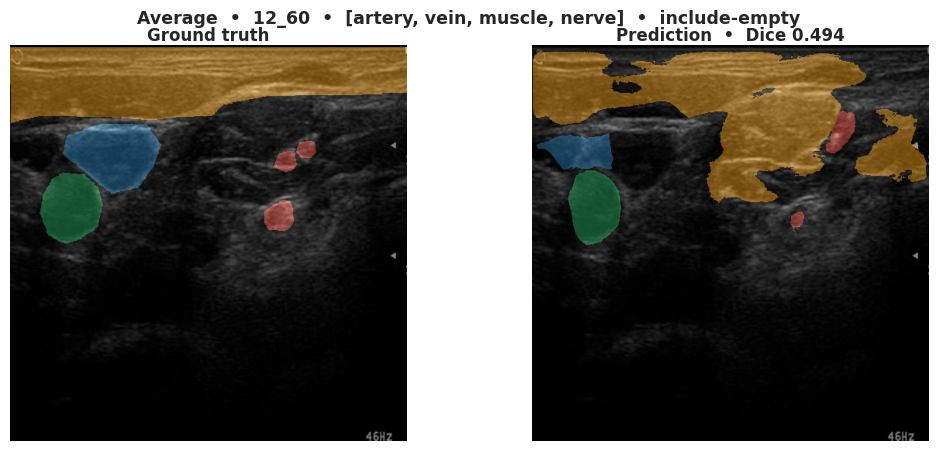

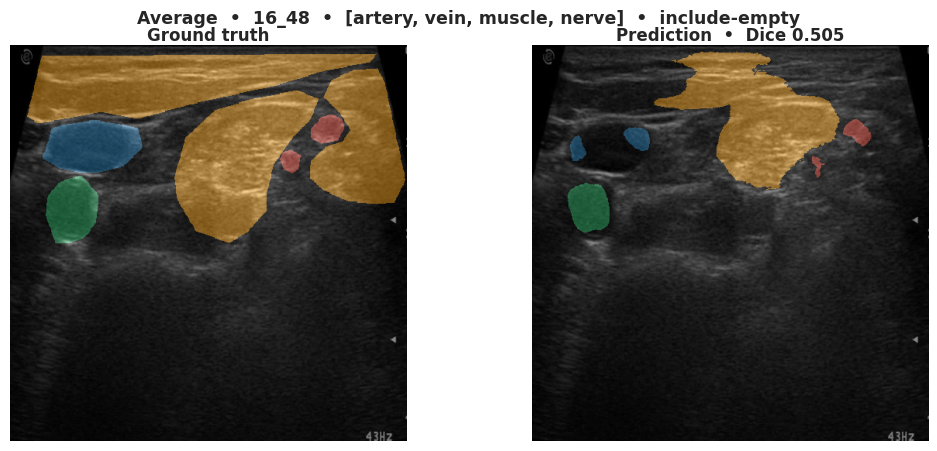

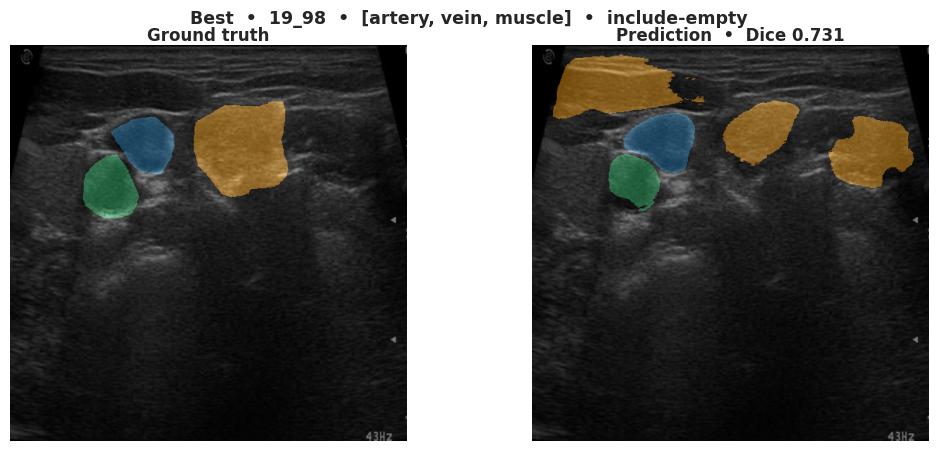

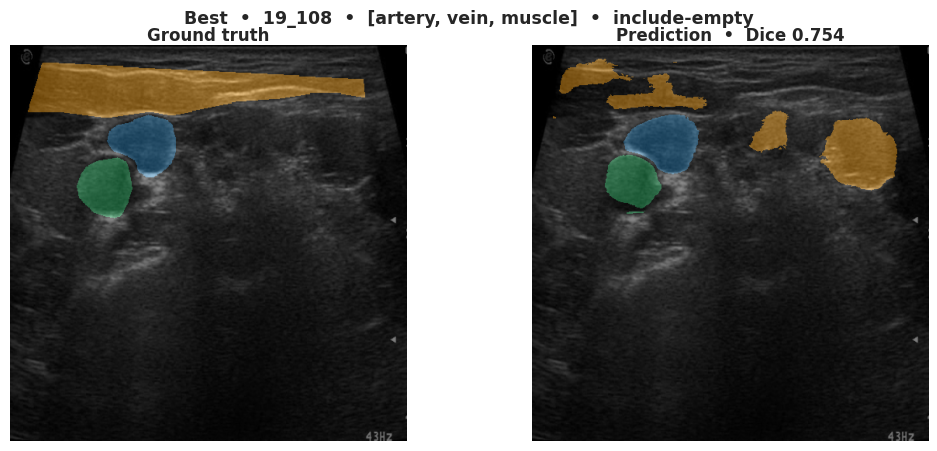


Evaluating: ../../checkpoints/111114_fold_4.pth ------------------

📊 Dice scores (foreground only; INCLUDING empties as Dice=1):
  Overall (pooled) mean±std: 0.3478 ± 0.3110  (n=208)
  artery               mean±std: 0.3151 ± 0.3151  (median=0.2012, n=52)
  vein                 mean±std: 0.4537 ± 0.3643  (median=0.5479, n=52)
  muscle               mean±std: 0.4667 ± 0.1818  (median=0.4346, n=52)
  nerve                mean±std: 0.1558 ± 0.2421  (median=0.0574, n=52)


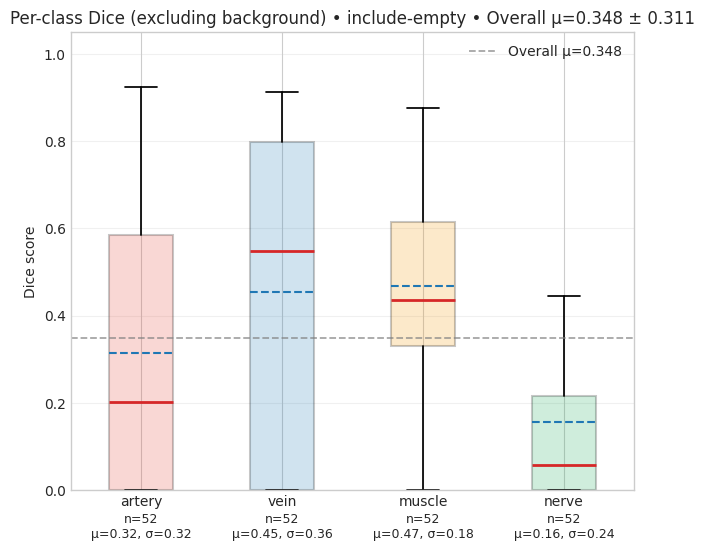

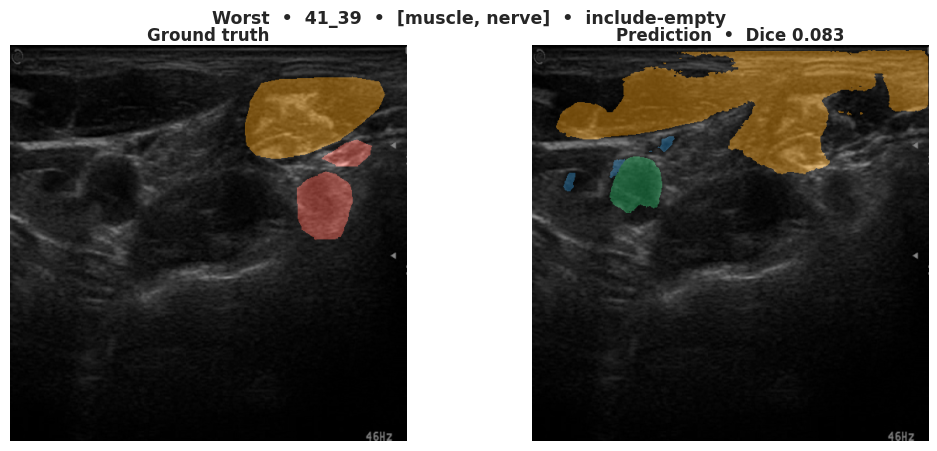

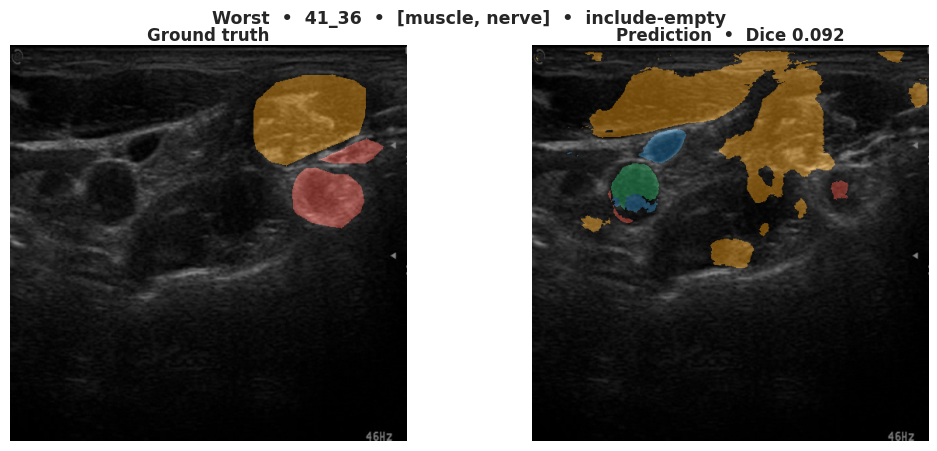

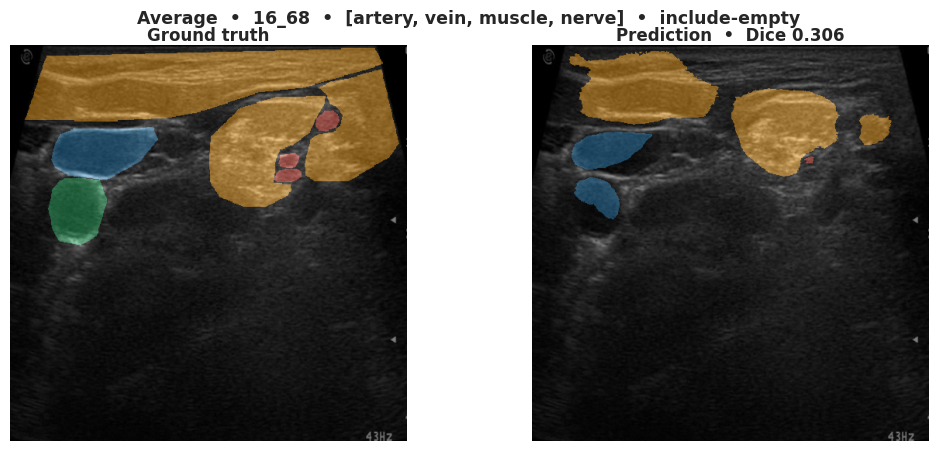

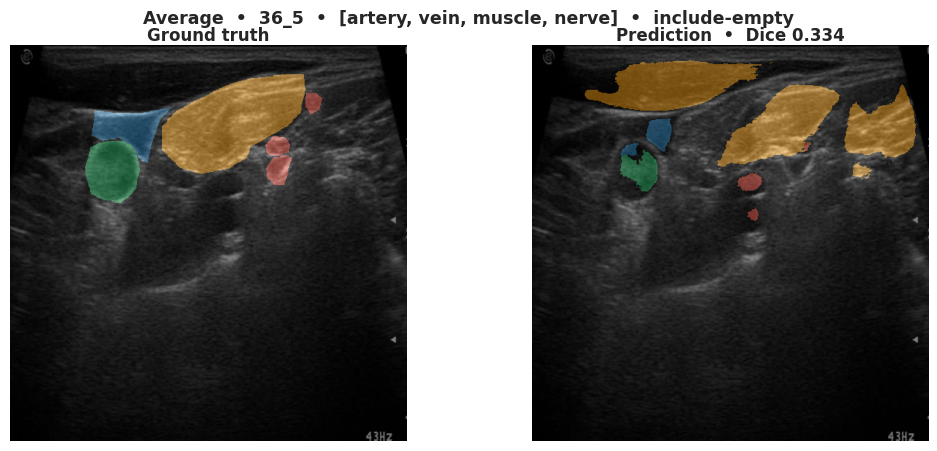

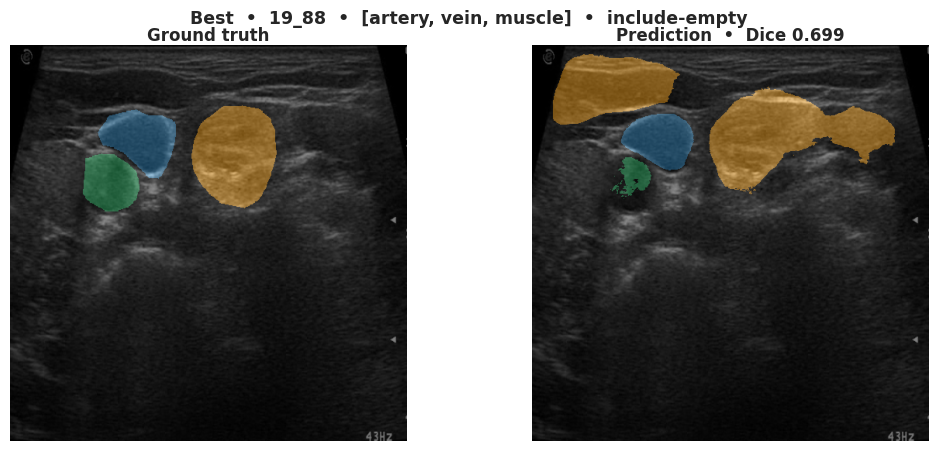

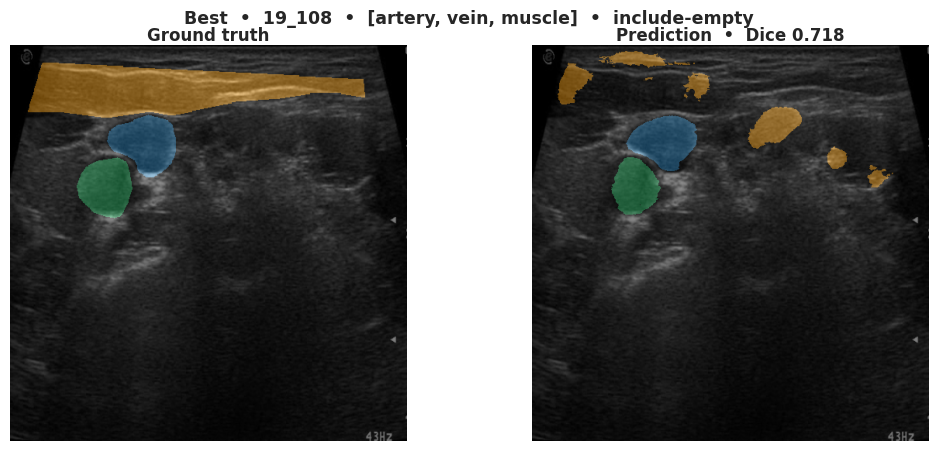


Evaluating: ../../checkpoints/111114_fold_5.pth ------------------

📊 Dice scores (foreground only; INCLUDING empties as Dice=1):
  Overall (pooled) mean±std: 0.4116 ± 0.3377  (n=208)
  artery               mean±std: 0.5445 ± 0.3505  (median=0.7238, n=52)
  vein                 mean±std: 0.4838 ± 0.3731  (median=0.5932, n=52)
  muscle               mean±std: 0.4915 ± 0.1939  (median=0.4885, n=52)
  nerve                mean±std: 0.1266 ± 0.2145  (median=0.0179, n=52)


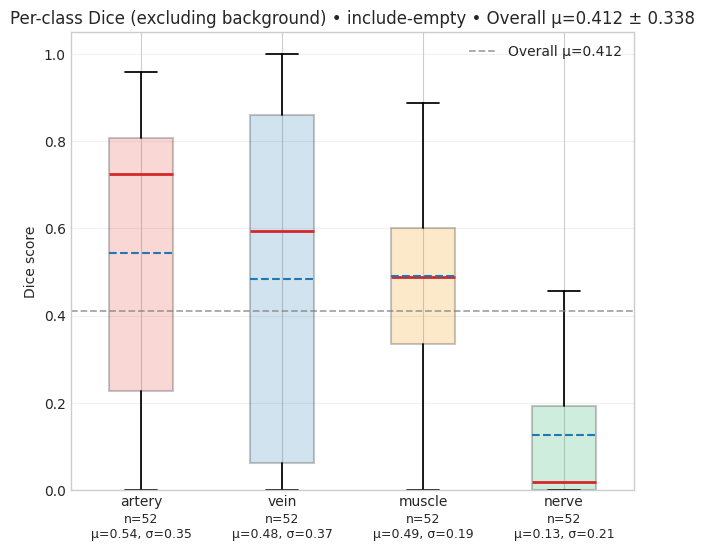

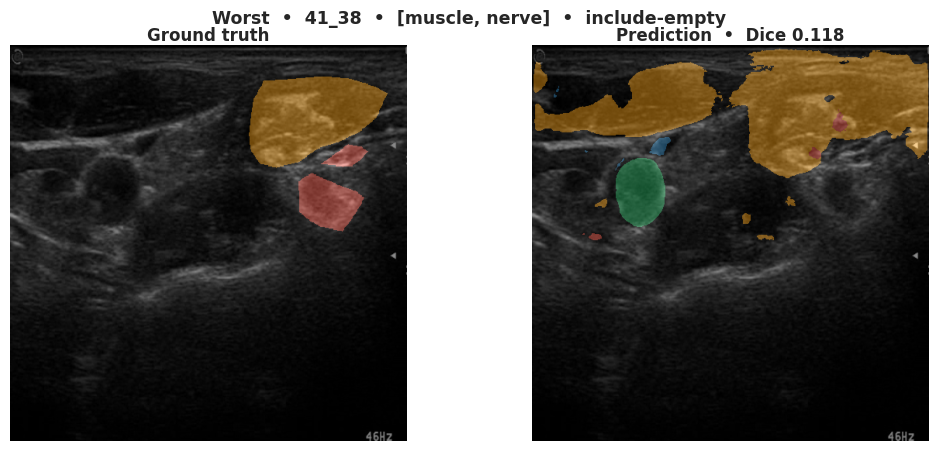

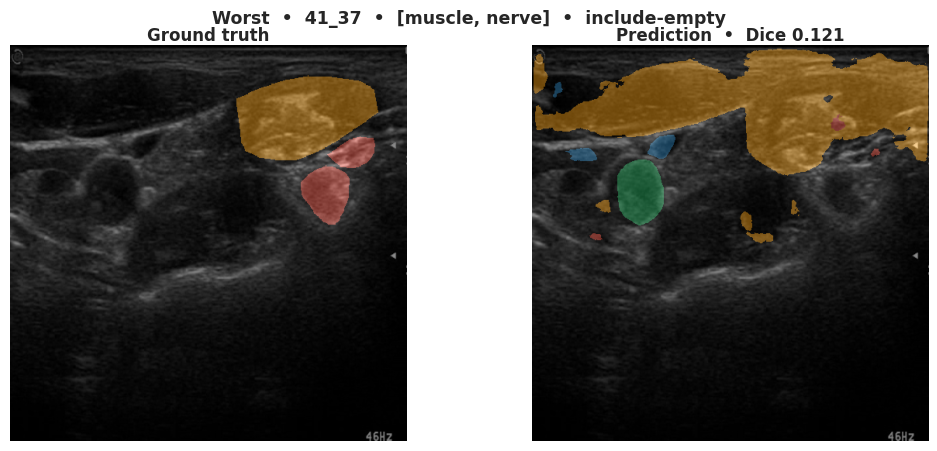

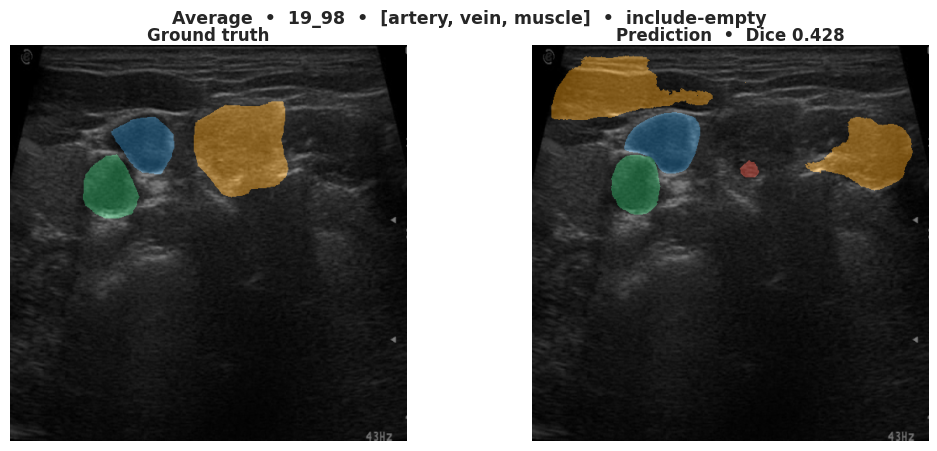

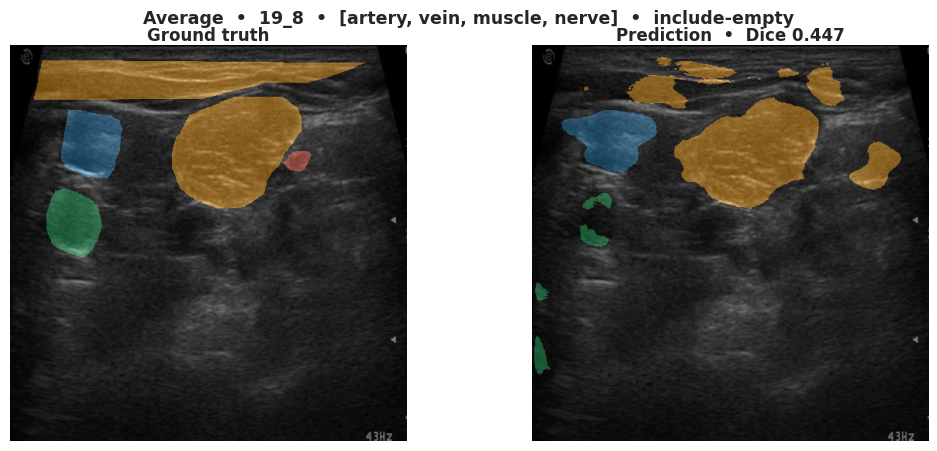

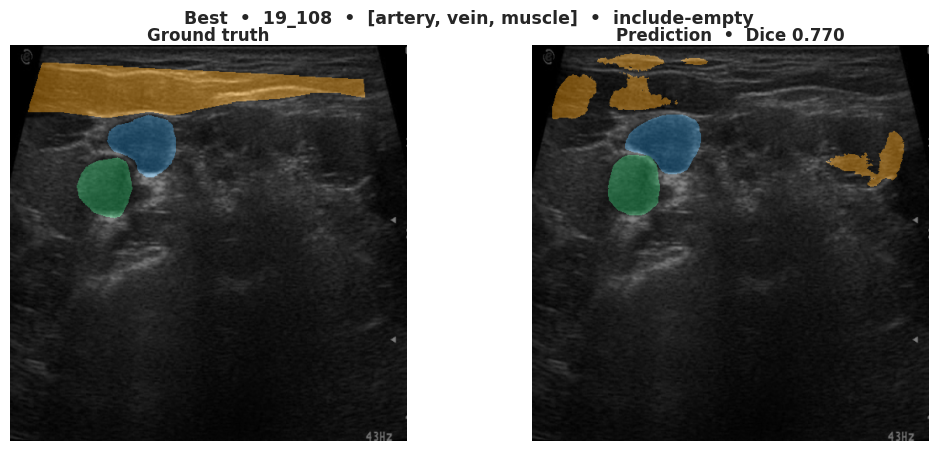

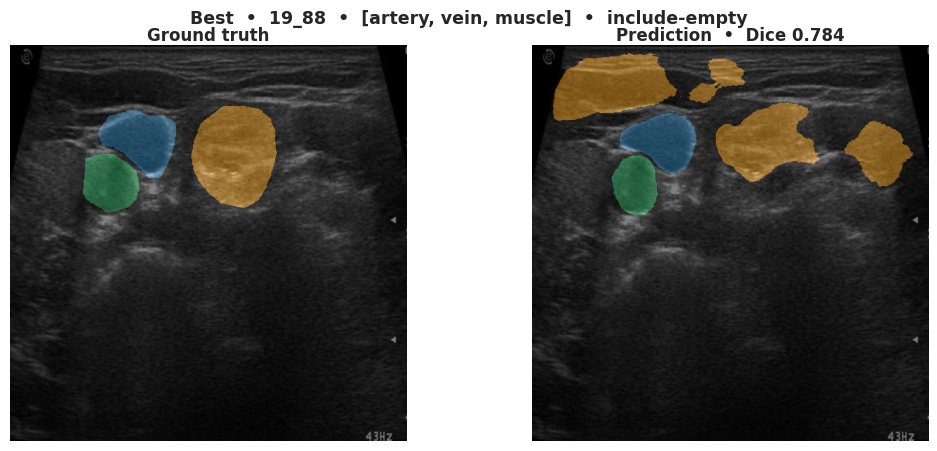


🎯 Average overall Dice across folds: 0.3681 ± 0.0457  (n=5)

📌 Per-landmark average Dice across folds:
  1: dongmai (artery)     mean±std: 0.4349 ± 0.1196  (folds=5)
  2: jingmai (vein)       mean±std: 0.4284 ± 0.0499  (folds=5)
  3: jirouzuzhi (muscle)  mean±std: 0.4885 ± 0.0235  (folds=5)
  4: shenjing (nerve)     mean±std: 0.1205 ± 0.0393  (folds=5)

✅ Experiment complete across folds.


In [15]:
result = evaluate(variants)

In [ ]:
result["fold_results"]